# Search Algorithms

:label:`course_alg`


## AutoGluon System Implementatin Logic

![](https://raw.githubusercontent.com/zhanghang1989/AutoGluonWebdata/master/doc/api/autogluon_system.png)

Important components of the AutoGluon system include the Searcher, Scheduler and Resource Manager:

- The Searcher suggests hyperparameter configurations for the next training job.
- The Scheduler runs the training job when computation resources become available.

In this tutorial, we illustrate how various search algorithms work and
compare their performance via toy experiments.

## FIFO Scheduling vs. Early Stopping

In this section, we compare the different behaviors of a sequential First In, First Out (FIFO) scheduler using :class:`autogluon.scheduler.FIFOScheduler` vs. a preemptive scheduling algorithm
:class:`autogluon.scheduler.HyperbandScheduler` that early-terminates certain training jobs that do not appear promising during their early stages.

### Create a Dummy Training Function

In [1]:
import numpy as np
import autogluon as ag

@ag.args(
    lr=ag.space.Real(1e-3, 1e-2, log=True),
    wd=ag.space.Real(1e-3, 1e-2))
def train_fn(args, reporter):
    for e in range(10):
        dummy_accuracy = 1 - np.power(1.8, -np.random.uniform(e, 2*e))
        reporter(epoch=e, accuracy=dummy_accuracy, lr=args.lr, wd=args.wd)

### FIFO Scheduler

This scheduler runs training trials in order. When there are more resources available than required for a single training job, multiple training jobs may be run in parallel.

In [2]:
scheduler = ag.scheduler.FIFOScheduler(train_fn,
                                       resource={'num_cpus': 2, 'num_gpus': 0},
                                       num_trials=20,
                                       reward_attr='accuracy',
                                       time_attr='epoch')
scheduler.run()
scheduler.join_jobs()


Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 20


Finished Task with config: {'lr': 0.0011307168688472417, 'wd': 0.007746055873448366} and reward: 0.9987710776248258
Finished Task with config: {'lr': 0.005646024543966616, 'wd': 0.0030570778814307284} and reward: 0.9995104379366804
Finished Task with config: {'lr': 0.001397936834616762, 'wd': 0.0076226521657866446} and reward: 0.9994946008106337
Finished Task with config: {'lr': 0.0031622777, 'wd': 0.0055} and reward: 0.9997084979745358
Finished Task with config: {'lr': 0.003291785973128472, 'wd': 0.001995829575530173} and reward: 0.9981324732151834
Finished Task with config: {'lr': 0.009746802005000976, 'wd': 0.007641267511921505} and reward: 0.9998127858805036
Finished Task with config: {'lr': 0.004184264695030874, 'wd': 0.006506473661170444} and reward: 0.9996418284140945
Finished Task with config: {'lr': 0.005378185640470667, 'wd': 0.009695306133904284} and reward: 0.9995987038392062
Finished Task with config: {'lr': 0.009820961984808608, 'wd': 0.005629661901432697} and reward: 0.9

Finished Task with config: {'lr': 0.0018809501139323956, 'wd': 0.002112824115858096} and reward: 0.9992405701254338
Finished Task with config: {'lr': 0.002188081629961302, 'wd': 0.004512974465647135} and reward: 0.9998253586497194
Finished Task with config: {'lr': 0.001984946177076318, 'wd': 0.008932131444689712} and reward: 0.9956597381250288
Finished Task with config: {'lr': 0.008451749810727778, 'wd': 0.0011382940220170002} and reward: 0.9981920526565943


Visualize the results:

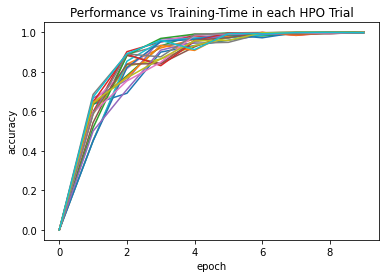

In [3]:
scheduler.get_training_curves(plot=True, use_legend=False)

### Hyperband Scheduler

The Hyperband Scheduler terminates training trials that don't appear promising during the early stages to free up compute resources for more promising hyperparameter configurations.

In [4]:
scheduler = ag.scheduler.HyperbandScheduler(train_fn,
                                            resource={'num_cpus': 2, 'num_gpus': 0},
                                            num_trials=20,
                                            reward_attr='accuracy',
                                            time_attr='epoch',
                                            grace_period=1)
scheduler.run()
scheduler.join_jobs()


Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 20


Finished Task with config: {'lr': 0.0031622777, 'wd': 0.0055} and reward: 0.9997699754494808
Finished Task with config: {'lr': 0.002614225397094559, 'wd': 0.0015729319121477875} and reward: 0.9363001183692645
Finished Task with config: {'lr': 0.0054603804934269095, 'wd': 0.005929383706003144} and reward: 0.9994296287730586
Finished Task with config: {'lr': 0.005908884211064137, 'wd': 0.00438489907200979} and reward: 0.999338740990627
Finished Task with config: {'lr': 0.0025514721867874474, 'wd': 0.004581643040131419} and reward: 0.6054625760180542
Finished Task with config: {'lr': 0.00957631678097124, 'wd': 0.006260667368179296} and reward: 0.5906063229485552
Finished Task with config: {'lr': 0.0016826978858466815, 'wd': 0.007830129464376334} and reward: 0.600553651320286
Finished Task with config: {'lr': 0.006512096812145744, 'wd': 0.002229407867032529} and reward: 0.999848989499412
Finished Task with config: {'lr': 0.0010862040450477298, 'wd': 0.003088340539993438} and reward: 0.5558

Finished Task with config: {'lr': 0.009714677207958827, 'wd': 0.0021051949570150656} and reward: 0.9966026462873852
Finished Task with config: {'lr': 0.0015517445577210903, 'wd': 0.004141643824608779} and reward: 0.4622331004750234
Finished Task with config: {'lr': 0.0015424146042061972, 'wd': 0.006040254397355476} and reward: 0.9999623401474572


Visualize the results:

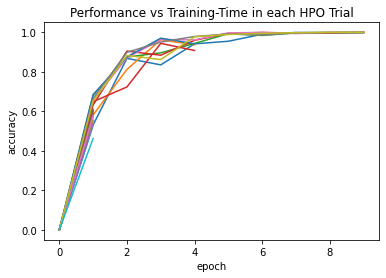

In [5]:
scheduler.get_training_curves(plot=True, use_legend=False)

## Random Search vs. Reinforcement Learning

In this section, we demonstrate the behaviors of random search and reinforcement learning
in a simple simulation environment.

### Create a Reward Function for Toy Experiments

Import the packages:

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Input Space `x = [0: 99], y = [0: 99]`.
The rewards is a combination of 2 gaussians as shown in the following figure:

Generate the simulated reward as a mixture of 2 gaussians:

In [7]:
def gaussian2d(x, y, x0, y0, xalpha, yalpha, A): 
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2) 

x, y = np.linspace(0, 99, 100), np.linspace(0, 99, 100) 
X, Y = np.meshgrid(x, y)

Z = np.zeros(X.shape) 
ps = [(20, 70, 35, 40, 1),
      (80, 40, 20, 20, 0.7)]
for p in ps:
    Z += gaussian2d(X, Y, *p)

Visualize the reward space:

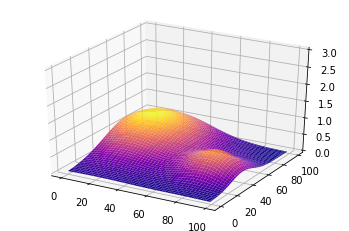

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d') 
ax.plot_surface(X, Y, Z, cmap='plasma') 
ax.set_zlim(0,np.max(Z)+2)
plt.show()

### Create Training Function

We can simply define an AutoGluon searchable function with a decorator `ag.args`.
The `reporter` is used to communicate with AutoGluon search and scheduling algorithms.

In [9]:
@ag.args(
    x=ag.space.Categorical(*list(range(100))),
    y=ag.space.Categorical(*list(range(100))),
)
def rl_simulation(args, reporter):
    x, y = args.x, args.y
    reporter(accuracy=Z[y][x])

### Random Search

In [10]:
random_scheduler = ag.scheduler.FIFOScheduler(rl_simulation,
                                              resource={'num_cpus': 1, 'num_gpus': 0},
                                              num_trials=300,
                                              reward_attr="accuracy",
                                              resume=False)
random_scheduler.run()
random_scheduler.join_jobs()
print('Best config: {}, best reward: {}'.format(random_scheduler.get_best_config(), random_scheduler.get_best_reward()))

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 300


Finished Task with config: {'x.choice': 0, 'y.choice': 0} and reward: 0.033741370964360654
Finished Task with config: {'x.choice': 63, 'y.choice': 44} and reward: 0.4714235575231762
Finished Task with config: {'x.choice': 30, 'y.choice': 82} and reward: 0.8423049539671549
Finished Task with config: {'x.choice': 1, 'y.choice': 40} and reward: 0.42435131177797863
Finished Task with config: {'x.choice': 97, 'y.choice': 65} and reward: 0.07902631001540152
Finished Task with config: {'x.choice': 36, 'y.choice': 30} and reward: 0.3028123315883148
Finished Task with config: {'x.choice': 48, 'y.choice': 51} and reward: 0.4607765146528751
Finished Task with config: {'x.choice': 76, 'y.choice': 91} and reward: 0.05969045547292743
Finished Task with config: {'x.choice': 59, 'y.choice': 32} and reward: 0.3152316636749103
Finished Task with config: {'x.choice': 82, 'y.choice': 6} and reward: 0.041869054970490524
Finished Task with config: {'x.choice': 85, 'y.choice': 12} and reward: 0.0965086780809

Finished Task with config: {'x.choice': 6, 'y.choice': 98} and reward: 0.522045776937697


Finished Task with config: {'x.choice': 22, 'y.choice': 42} and reward: 0.6107835341537289
Finished Task with config: {'x.choice': 91, 'y.choice': 19} and reward: 0.17496937137404278


Best config: {'x.choice': 17, 'y.choice': 72}, best reward: 0.9902040382974465


### Reinforcement Learning

In [11]:
rl_scheduler = ag.scheduler.RLScheduler(rl_simulation,
                                        resource={'num_cpus': 1, 'num_gpus': 0},
                                        num_trials=300,
                                        reward_attr="accuracy",
                                        controller_batch_size=4,
                                        controller_lr=5e-3)
rl_scheduler.run()
rl_scheduler.join_jobs()
print('Best config: {}, best reward: {}'.format(rl_scheduler.get_best_config(), rl_scheduler.get_best_reward()))

Reserved DistributedResource(
	Node = Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.16.17.200/11794/1' processes=1 threads=8, memory=64.38 GB>
	nCPUs = 0) in Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.16.17.200/11794/1' processes=1 threads=8, memory=64.38 GB>
Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 300


Finished Task with config: {'x.choice': 54, 'y.choice': 60} and reward: 0.4131320021194963
Finished Task with config: {'x.choice': 59, 'y.choice': 85} and reward: 0.25248241948989986
Finished Task with config: {'x.choice': 71, 'y.choice': 54} and reward: 0.452177348673922
Finished Task with config: {'x.choice': 84, 'y.choice': 84} and reward: 0.03655423885462522
Finished Task with config: {'x.choice': 42, 'y.choice': 43} and reward: 0.44561928050295485
Finished Task with config: {'x.choice': 62, 'y.choice': 29} and reward: 0.3129734289166378
Finished Task with config: {'x.choice': 64, 'y.choice': 89} and reward: 0.16521724999224768
Finished Task with config: {'x.choice': 38, 'y.choice': 5} and reward: 0.055140459703497166
Finished Task with config: {'x.choice': 96, 'y.choice': 79} and reward: 0.01675323386032184
Finished Task with config: {'x.choice': 27, 'y.choice': 80} and reward: 0.9025895808289532
Finished Task with config: {'x.choice': 38, 'y.choice': 52} and reward: 0.63282275329


Best config: {'x.choice': 21, 'y.choice': 74}, best reward: 0.9892484241569526


### Compare the performance

Get the result history:

In [12]:
results_rl = [v[0]['accuracy'] for v in rl_scheduler.training_history.values()]
results_random = [v[0]['accuracy'] for v in random_scheduler.training_history.values()]

Average result every 10 trials:

In [13]:
import statistics
results1 = [statistics.mean(results_random[i:i+10]) for i in range(0, len(results_random), 10)]
results2 = [statistics.mean(results_rl[i:i+10]) for i in range(0, len(results_rl), 10)]

Plot the results:

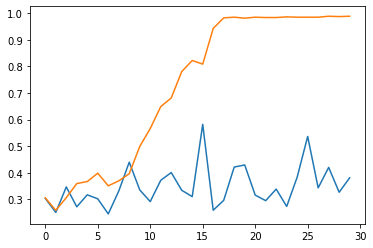

In [14]:
plt.plot(range(len(results1)), results1, range(len(results2)), results2)